# Functions

In [9]:
import math
import numpy as np
from matplotlib import pyplot as plt

In [10]:
#Binomial distribution
def binom(n,p):
    P_w = np.zeros(n+1)
    for k in range(len(P_w)):
        P_w[k] = p**k * (1-p)**(n-k) * math.factorial(n)/(math.factorial(k)*math.factorial(n-k))
    return P_w

#h() in per-step cost
def h(s,ch,cs):
    if s >= 0:
        return ch*s
    else:
        return -cs*s

#One-step optimality Bellman operator
def bellman_opt(V,W,gamma = 0.75,p = 5,ch = 4,cs = 2):
    num_states = len(V)
    state_bound = int((num_states - 1)/2)
    action_bound = state_bound
    states = np.linspace(-state_bound,state_bound,num_states)
    Q = np.zeros((num_states,action_bound+1))

    for i in range(num_states):
        s = states[i]
        for a in range(action_bound+1):
            sum = 0
            for w in range(len(W)):
                next_state = min(max(s+a-w,-state_bound),state_bound)
                sum += V[int(next_state) + state_bound] * W[w]
            Q[i,a] = p * a + h(s,ch,cs) + gamma * sum

    pi = np.argmin(Q,axis=1)
    BV = Q[np.arange(len(Q)),pi]
    return BV

#One-step Bellman operator for a given policy
def bellman_pi(V,W,pi,gamma = 0.75,p = 5,ch = 4,cs = 2):
    num_states = len(V)
    state_bound = int((num_states-1)/2)
    action_bound = state_bound
    states = np.linspace(-state_bound,state_bound,num_states)
    BV = np.zeros(num_states)
    for i in range(num_states):
        s = states[i]
        sum = 0
        for w in range(len(W)):
            next_state = min(max(s+pi[i]-w,-state_bound),state_bound)
            sum += V[int(next_state) + state_bound] * W[w]
        BV[i] = p * pi[i] + h(s,ch,cs) + gamma * sum
    return BV

def bellman_opt_alpha_beta(V,W,alpha = 1,beta = 0,gamma = 0.75,p = 5,ch = 4,cs = 2):
    num_states = len(V)
    state_bound = int((num_states - 1)/2)
    action_bound = state_bound
    states = np.linspace(-state_bound,state_bound,num_states)
    Q = np.zeros((num_states,action_bound+1))

    for i in range(num_states):
        s = states[i]
        for a in range(action_bound+1):
            sum = 0
            for w in range(len(W)):
                next_state = min(max(s+a-w,-state_bound),state_bound)
                sum += V[int(next_state) + state_bound] * W[w]
            Q[i,a] = beta + alpha * (p * a + h(s,ch,cs)) + gamma * sum

    pi = np.argmin(Q,axis=1)
    BV = Q[np.arange(len(Q)),pi]
    return BV

def bellman_pi_alpha_beta(V,W,pi,alpha = 1, beta = 0, gamma = 0.75,p = 5,ch = 4,cs = 2):
    num_states = len(V)
    state_bound = int((num_states-1)/2)
    action_bound = state_bound
    states = np.linspace(-state_bound,state_bound,num_states)
    BV = np.zeros(num_states)
    for i in range(num_states):
        s = states[i]
        sum = 0
        for w in range(len(W)):
            next_state = min(max(s+pi[i]-w,-state_bound),state_bound)
            sum += V[int(next_state) + state_bound] * W[w]
        BV[i] = beta + alpha * (p * pi[i] + h(s,ch,cs)) + gamma * sum
    return BV

#evaluate the optimal policy of the approximate model on the true model
def policy_eval(W,pi_hat,gamma = 0.75,p = 5,ch = 4,cs = 2,thres = 1e-6):
    delta = 0
    V = np.zeros(len(pi_hat))
    t = 0
    while True:
        V_new = bellman_pi(V,W,pi_hat,gamma,p,ch,cs)
        delta = np.max(np.abs(V-V_new))
        V = V_new
        if delta < thres:
            break
    return V

#Fast DP-c(s,a) = pa + h(s)
def dp(s_max,W,gamma = 0.75,p = 5,ch = 4,cs = 2,thres = 1e-4):
    V = np.zeros(2*s_max + 1)
    H = np.zeros(3*s_max + 1)
    pi = np.zeros(len(V))
    t = 0
    while True:
        for z in range(-s_max,2*s_max+1):
            H[z + s_max] = 0
            for w in range(len(W)):
                next_state = min(max(z-w,-s_max),s_max)
                H[z + s_max] += V[next_state + s_max] * W[w]
        delta = 0
        for s in range(-s_max,s_max+1):
            opt = 0
            val = gamma * H[s + s_max]
            for a in range(1,s_max+1):
                new_val = p * a + h(s,ch,cs) + gamma * H[min(s+a, 2*s_max) + s_max]
                if new_val <= val:
                    opt = a
                    val = new_val
            delta = max(delta,abs(val-V[s+s_max]))
            pi[s + s_max] = opt
            V[s + s_max] = val
        if delta < thres:
            break
    return V,pi

#Intermediate bound
def bound_v_hat(V,weight,W,W_hat,kappa = 1,gamma = 0.75,p = 5,p_hat = 5,ch = 4,ch_hat = 6,cs = 2,cs_hat = 2):
    mismatch_opt = np.max(np.abs(bellman_opt(V,W,gamma,p,ch,cs) - bellman_opt(V,W_hat,gamma,p_hat,ch_hat,cs_hat))/weight)
    return (1 / (1-gamma*kappa)) * mismatch_opt

#First bound of Thm. 1
def bound_v_pi(V,pi,weight,W,W_hat,kappa = 1,gamma = 0.75,p = 5,p_hat = 5,ch = 4,ch_hat = 6,cs = 2,cs_hat = 2):
    mistmatch_opt = np.max(np.abs(bellman_opt(V,W,gamma,p,ch,cs) - bellman_opt(V,W_hat,gamma,p_hat,ch_hat,cs_hat))/weight)
    mismatch_pi = np.max(np.abs(bellman_pi(V,W,pi,gamma,p,ch,cs) - bellman_pi(V,W_hat,pi,gamma,p_hat,ch_hat,cs_hat))/weight) #add ch_hat etc.
    return (1 / (1-gamma*kappa)) * (mistmatch_opt + mismatch_pi)

def bound_alpha_beta(V,pi,weight,W,W_hat,alpha = 1, beta = 0, kappa = 1,gamma = 0.75,p = 5,p_hat = 5,ch = 4,ch_hat = 6,cs = 2,cs_hat = 2):
    mistmatch_opt = np.max(np.abs(bellman_opt_alpha_beta(V,W,alpha,beta,gamma,p,ch,cs) - bellman_opt(V,W_hat,gamma,p_hat,ch_hat,cs_hat))/weight)
    mismatch_pi = np.max(np.abs(bellman_pi_alpha_beta(V,W,pi,alpha,beta,gamma,p,ch,cs) - bellman_pi(V,W_hat,pi,gamma,p_hat,ch_hat,cs_hat))/weight) #add ch_hat etc.
    return (1 / (1-gamma*kappa)) * (1/alpha) * (mistmatch_opt + mismatch_pi)

def find_K(weight,pi,W):
    num_states = len(weight)
    s_max = int((num_states-1)/2)
    LHS = np.zeros(num_states)
    states = np.linspace(-s_max,s_max,num_states)
    for i,s in enumerate(states):
        for w in range(len(W)):
            next_state = min(max(s+pi[i]-w,-s_max),s_max)
            LHS[i] += weight[int(next_state) + s_max] * W[w]
    return np.max(LHS/weight)

#not for a specific policy, for all actions
def find_K_all(weight,W):
    num_states = len(weight)
    s_max = int((num_states - 1) / 2)
    num_actions = s_max + 1
    LHS = np.zeros((num_states,num_actions))
    states = np.linspace(-s_max,s_max,num_states)
    for i in range(num_states):
        for j in range(num_actions):
            for w in range(len(W)):
                next_state = min(max(states[i] + j - w,-s_max),s_max)
                LHS[i,j] += weight[int(next_state) + s_max] * W[w]

    return np.max(LHS / weight[:,None])
def find_largest_alpha(alphas):
    s_max = 500
    W = binom(10,0.4)
    W_hat = binom(10,0.5)
    ch_hat = 3.8
    cs_hat = 2
    V_star,pi_star = dp(s_max = s_max, W = W, gamma = 0.75, p = 5, ch = 4, cs = 2, thres = 1e-4)
    V_hat_star,pi_hat_star = dp(s_max = s_max, W = W_hat, gamma = 0.75, p = 5, ch = ch_hat, cs = cs_hat, thres = 1e-4)

    vh = np.vectorize(h)
    states = np.linspace(-s_max,s_max,2*s_max+1)
    kappa_list = []
    kappa_act_list = []
    for alpha in alphas:
        weight = 1 + alpha * vh(states, ch = ch_hat, cs = cs_hat)
        kappa = max(find_K(weight,pi_star,W),find_K(weight,pi_hat_star,W))
        kappa_list.append(kappa)
        k = max(find_K_all(weight,W),find_K_all(weight,W_hat))
        kappa_act_list.append(k)
    return kappa_act_list, kappa_list

In [3]:
def build_curves(gamma = 0.75,n = 10, n_hat = 10, q = 0.4, q_hat = 0.5 , ch = 4, ch_hat = 3.8, p = 5, p_hat = 5, cs = 2, cs_hat = 2, s_max = 100, thres = 1e-4, alphas = [0]):
    W = binom(n,q)
    W_hat = binom(n_hat,q_hat)
    states = np.linspace(-s_max,s_max,2*s_max+1)
    V_star,pi_star = dp(s_max = s_max, W = W, gamma = gamma, p = p, ch = ch, cs = cs, thres = thres)
    V_hat_star,pi_hat_star = dp(s_max = s_max, W = W_hat, gamma = gamma, p = p, ch = ch_hat, cs = cs, thres = thres)
    V_pi_hat_star = policy_eval(W,pi_hat_star,gamma = gamma,p = p,ch = ch,cs = cs,thres = 1e-6)
    kappa_list = []
    bounds = []
    curves = []
    vh = np.vectorize(h)
    for alpha in alphas:
        #weight = 1 + alpha * np.abs(states)

        weight = 1 + alpha * vh(states, ch = ch_hat, cs = cs_hat)
        # weight = (V_hat_star) / np.min(V_hat_star)
        kappa_found = max(find_K(weight,pi_star,W),find_K(weight,pi_hat_star,W),find_K(weight,pi_hat_star,W_hat))
        assert kappa_found < (1 / gamma), "kappa should be less than 1/gamma"
        kappa_list.append(kappa_found)
        bound =  bound_v_pi(V_hat_star,pi_hat_star,weight,W,W_hat,kappa = kappa_found, gamma = gamma, p = p, p_hat = p_hat, ch = ch,ch_hat = ch_hat, cs = cs, cs_hat = cs_hat)
        bound_curve = bound * weight
        bounds.append(bound)
        curves.append(bound_curve)
    return V_pi_hat_star,V_hat_star, V_star, kappa_list,bounds,curves


def build_curves_alpha_beta(alphas = [1],betas = [0], gamma = 0.75,n = 10, n_hat = 10, q = 0.4, q_hat = 0.5 , ch = 4, ch_hat = 3.8, p = 5, p_hat = 5, cs = 2, cs_hat = 2, s_max = 100, thres = 1e-4, epsilons = [0]):
    W = binom(n,q)
    W_hat = binom(n_hat,q_hat)
    states = np.linspace(-s_max,s_max,2*s_max+1)
    V_star,pi_star = dp(s_max = s_max, W = W, gamma = gamma, p = p, ch = ch, cs = cs, thres = thres)
    V_hat_star,pi_hat_star = dp(s_max = s_max, W = W_hat, gamma = gamma, p = p, ch = ch_hat, cs = cs, thres = thres)
    V_pi_hat_star = policy_eval(W,pi_hat_star,gamma = gamma,p = p,ch = ch,cs = cs,thres = 1e-6)
    kappa_list = []
    bounds = []
    curves = []
    combinations = []
    vh = np.vectorize(h)
    for epsilon in epsilons:
        weight = 1 + epsilon * vh(states, ch = ch_hat, cs = cs_hat)
        # weight = (V_hat_star) / np.min(V_hat_star)
        kappa_found = max(find_K(weight,pi_star,W),find_K(weight,pi_hat_star,W),find_K(weight,pi_hat_star,W_hat))
        #kappa_found = find_K_all(weight,W)
        #kappa_found = max(find_K_all(weight,W),find_K_all(weight,W_hat)) #for the more general notion of stability
        assert kappa_found < (1 / gamma), "kappa should be less than 1/gamma"
        kappa_list.append(kappa_found)
        for alph in alphas:
            for beta in betas:
                #weight = 1 + alpha * np.abs(states)
                bound =  bound_alpha_beta(V_hat_star,pi_hat_star,weight,W,W_hat,alpha = alph,beta = beta,kappa = kappa_found, gamma = gamma, p = p, p_hat = p_hat, ch = ch,ch_hat = ch_hat, cs = cs, cs_hat = cs_hat)
                bound_curve = bound * weight
                bounds.append(bound)
                curves.append(bound_curve)
                combinations.append((epsilon,alph,beta))
    return V_pi_hat_star,V_hat_star, V_star, kappa_list,bounds,curves,combinations

In [11]:
def plot_curves(V_pi_hat_star,combs,curves):

    NUM_COLORS = len(curves)
    cm = plt.get_cmap('hot')
    plt.rcParams['pdf.fonttype'] = 42
    fig = plt.figure(figsize=(3, 2), dpi=150)
    ax = fig.add_subplot()
    ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    curv_arr = np.asarray(curves)
    curv_arr = V_pi_hat_star - curv_arr
    inds = np.argmin(np.abs(curv_arr - V_pi_hat_star),axis = 0)
    new_curve = np.zeros(len(curves[0]))


    clr_list = ['#1f77b4','#ff7f0e', '#d62728', '#8c564b', '#e377c2', '#bcbd22']
    for i in range(len(curves[0])):
        new_curve[i] = curves[inds[i]][i]

    #-----------------------------zoomed out----------------------------------
    s_max = int((len(V_pi_hat_star) - 1) / 2)
    states = states = np.linspace(-s_max,s_max,2*s_max+1)
    ax.plot(states,V_pi_hat_star, label = '$V^{\hat\pi^\star}$',linewidth = 1,color = 'green')
    ind = 0

    for curve in curves:
        comb_str = str(combs[ind])
        if ind == 0:
            ax.plot(states,V_pi_hat_star-curve, label = f'ℓ = {combs[ind][0]}',linewidth = 1,color = clr_list[ind])
        else:
        #     # ax.plot(states,V_pi_hat_star-curve, label = f'α = {combs[ind][0]}',linewidth = 1, color = '#8c564b')
        #     ax.plot(states,V_pi_hat_star-curve, label = 'sup norm lower bound',linewidth = 1, color = '#1f77b4')
        # else:
        #     ax.plot(states,V_pi_hat_star-curve, label = f'α = {combs[ind][0]:.1e}',linewidth = 1,color = clr_list[ind])
            ax.plot(states,V_pi_hat_star-curve, label = f'ℓ = {combs[ind][0]:.2e}',linewidth = 1,color = clr_list[ind])
        ind += 1
    ax.fill_between(states,V_pi_hat_star,V_pi_hat_star - new_curve, alpha = 0.2, label = 'error band',color = 'red')
    plt.legend(loc = 'best', fontsize = 5, ncol = 2)
    plt.ylim(-1000,5000)
    plt.yticks(np.arange(-1000,5000+1,1000))
    plt.xlim(-s_max,s_max)
    plt.xticks(np.arange(-s_max,s_max+1,s_max/2))
    plt.grid()
    plt.xlabel('state')
    plt.ylabel('value')
    plt.savefig('multi_out_500.pdf',format="pdf", bbox_inches="tight")
    plt.show()

    #-----------------------------zoomed in----------------------------------
    cm = plt.get_cmap('hot')
    fig = plt.figure(figsize=(3, 2), dpi=150)
    ax = fig.add_subplot()
    # ax.set_facecolor('lightgray')
    ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    s_max = int((len(V_pi_hat_star) - 1) / 2)
    states = states = np.linspace(-s_max,s_max,2*s_max+1)
    ax.step(states,V_pi_hat_star, label = '$V^{\hat\pi^\star}$',linewidth = 1, color = 'green')
    ind = 0
    for curve in curves:
        comb_str = str(combs[ind])
        # ax.step(states,V_pi_hat_star-curve, label = f'(ℓ,α,β) = {comb_str}',linewidth = 1)
        ax.step(states,V_pi_hat_star-curve, label = f'α = {combs[ind][0]:.1e}',linewidth = 1,color = clr_list[ind])

        # if ind == 0:
        #     ax.step(states,V_pi_hat_star-curve, label = 'sup norm lower bound',linewidth = 1, color = '#1f77b4')
        # else:
        #     ax.step(states,V_pi_hat_star-curve, label = f'α = {combs[ind][0]:.1e}',linewidth = 1,color = clr_list[ind])
        ind += 1

    ax.fill_between(states,V_pi_hat_star,V_pi_hat_star - new_curve, alpha = 0.2, color = 'red', step = 'pre', label = 'sup norm error band')
    # plt.legend(loc = 'upper left', fontsize = 5.5, ncol = 1)
    plt.ylim(-25,150)
    plt.yticks(np.arange(-25,150+1,25))
    plt.xticks(np.arange(-10, 10+1, 5.0))
    plt.xlim(-10,10)
    plt.grid()
    plt.xlabel('state')
    plt.ylabel('value')
    plt.savefig('multi_in_500.pdf',format="pdf", bbox_inches="tight")
    plt.show()

    #-----------------------------zoomed out----------------------------------
    plt.figure(figsize=(3,2),dpi = 150)
    s_max = int((len(V_pi_hat_star) - 1) / 2)
    states = states = np.linspace(-s_max,s_max,2*s_max+1)
    plt.plot(states,V_pi_hat_star, label = '$V^{\hat\pi^\star}$',linewidth = 1.25, color = 'green')
    plt.fill_between(states,V_pi_hat_star,V_pi_hat_star - new_curve, color = 'red', alpha = 0.2, label = 'error band')
    plt.legend(loc = 'lower left', fontsize = 6, ncol = 1)
    plt.ylim(-2000,6000)
    plt.xlim(-s_max,s_max)

    plt.grid()
    plt.xlabel('state')
    plt.ylabel('value')
    plt.show()

    #-----------------------------zoomed in----------------------------------
    plt.figure(figsize=(3,2),dpi = 150)
    s_max = int((len(V_pi_hat_star) - 1) / 2)
    states = states = np.linspace(-s_max,s_max,2*s_max+1)
    plt.step(states,V_pi_hat_star, label = '$V^{\hat\pi^\star}$',linewidth = 1.25,color = 'green')
    plt.fill_between(states,V_pi_hat_star,V_pi_hat_star - new_curve, color = 'red', alpha = 0.2,step = 'pre', label = 'error band')
    plt.legend(loc = 'lower left', fontsize = 6, ncol = 1)
    plt.ylim(-150,150)
    plt.xticks(np.arange(-10, 10+1, 5.0))
    plt.xlim(-10,10)
    plt.grid()
    plt.xlabel('state')
    plt.ylabel('value')
    plt.show()

# Tests

### per-step cost change for CDC final

In [12]:
# l_arr = [0,1.5*1e-2]
l_arr = [1.5*1e-2]
# l_arr = [0]
l_arr = np.linspace(0,2.5*1e-2,6)
# l_arr = np.linspace(0,1.25*1e-4,6)
V_pi_hat_star,V_hat_star, V_star, kappa_list,bounds,curves,combinations = build_curves_alpha_beta( s_max = 500, epsilons = l_arr)

In [ ]:
#Sanity check for kappa using all actions (more general stability)
s_max = 500
n = 10
n_hat = 10
q = 0.4
q_hat = 0.5
W = binom(n,q)
W_hat = binom(n_hat,q_hat)
states = np.linspace(-s_max,s_max,2*s_max+1)
epsilon = 2e-04
ch_hat = 3.8
cs_hat = 2
vh = np.vectorize(h)
weight = 1 + epsilon * vh(states, ch = ch_hat, cs = cs_hat)
kappa = max(find_K_all(weight,W),find_K_all(weight,W_hat))

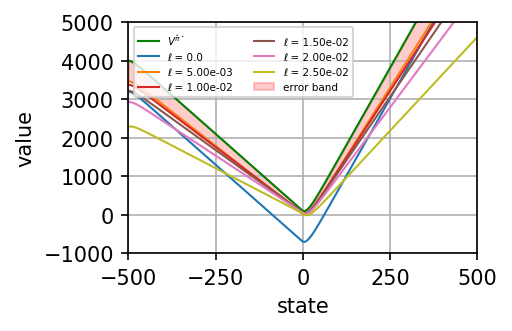

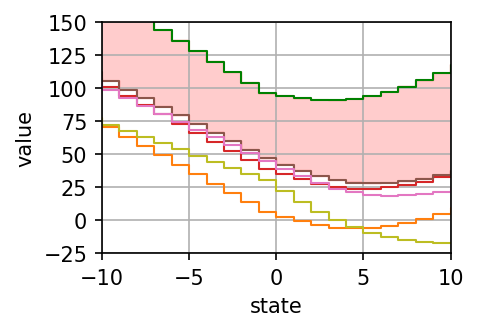

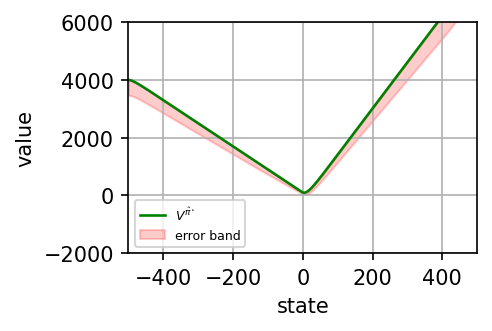

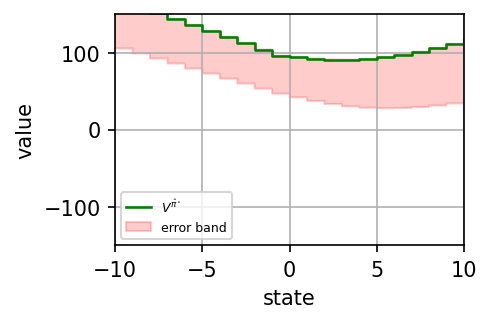

In [13]:
plot_curves(V_pi_hat_star,combinations,curves)